# **Zápočtová úloha**

Počty obětí koronaviru v zadaném italském regionu proložte exponencielním modelem:

$$ \log(y) = l_m - l_0 \exp(-l_1 x) = l_m - \exp(p_0 + p_1 x) \tag{1},$$

kde horní limita $l_m$ byla určena iterativně: $l_m = 5.685 \pm 0.024$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
plt.rc("font", size=12)

In [2]:
data = np.loadtxt("data_461281.txt")
days, deaths = data[:,0], data[:,1]
N = 32
lm = 5.685
lm_e = 0.024

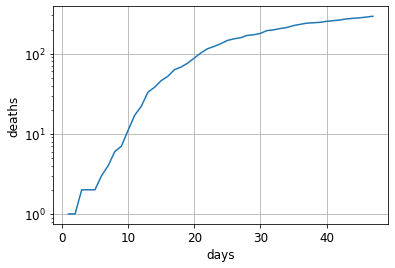

In [3]:
plt.yscale("log")
plt.xlabel("days")
plt.ylabel("deaths")
plt.grid()
p=plt.plot(days, deaths)

## <div align="justify"> A) Proložte data křivkou dle výrazu (1) za předpokladu, že měření jsou zatížena nejistotou odpovídající Poissonovu rozdělení (pracujte s aproximací P. veličin normálním rozdělením). K nalezení parametrů použijte měření do dne 32 od počátku měření </div>
### <div align="justify"> 1. transformujte měřenou veličinu při použití zadané horní limity a určete nejistoty po transformaci, použijte maticový formalismus pro vyřešení lineárního modelu (určení zbývajících parametrů $p_0$ a $p_1$)</div>
<div align="justify">Původní model (1) linearizuji a získám novou proměnnou $z = \log \left( l_m - \log(y) \right)$. Odpovídající nejistotu $\sigma_z$ získám ze zákona šíření chyb, kde pro měřenou veličinu $y$ předpokládám Poissonovo rozdělení $\Rightarrow \; D(y) = \sigma_y^2 = y$.</div>

$$\sigma_z = \sqrt{\sigma_y^2 \, \left( \frac{\partial z}{\partial y} \right)^2 + \sigma_{l_m}^2 \, \left( \frac{\partial z}{\partial l_m} \right)^2}= \sqrt{y \, \frac{1}{(l_m - \log(y))^2} \, \frac{1}{y^2} + \sigma_{l_m}^2 \, \frac{1}{(l_m - \log(y))^2}}$$

In [4]:
x, y = days[:N], deaths[:N]
z = np.log(lm - np.log(y))
z_e_lm = lm_e / (lm - np.log(y))
z_e_y = 1 / (np.sqrt(y) * (lm - np.log(y)))
z_e = np.sqrt(z_e_lm**2 + z_e_y**2)

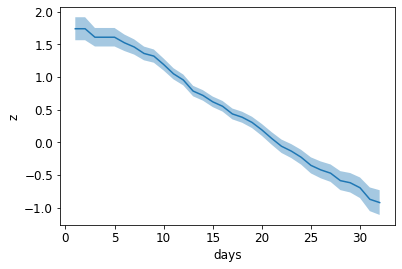

In [5]:
plt.ylabel("z")
plt.xlabel("days")
plt.fill_between(x, z-z_e, z+z_e, alpha=0.4)
p=plt.plot(x, z)

Průběh veličiny $z$ proložím lineárním modelem, který vyřeším maticově po vzoru [vašeho rozboru](https://is.muni.cz/auth/el/sci/jaro2020/F7270/um/prezen/Corona_vyvoj.html). Pro váhovou matici bude platit:

$$W_{ii} = 1 \, / \, D(z_i) = 1 \, / \, \sigma_z^2.$$

In [6]:
w = np.eye(N)
i = np.r_[:N]
w[i,i] = 1 / z_e**2
A = np.array([np.ones_like(x), x]).T
hess = A.T @ w @ A
par = np.linalg.inv(hess) @ A.T @ w @ z
p0, p1 = par[0], par[1]
print("p0 = {0:.6f}\np1 = {1:.6f}".format(p0, p1))

p0 = 2.049011
p1 = -0.093755


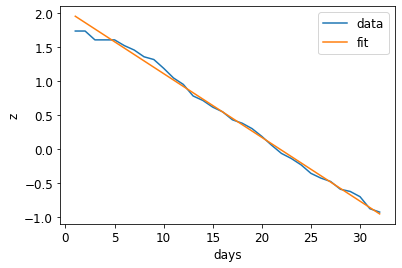

In [7]:
plt.ylabel("z")
plt.xlabel("days")
plt.plot(x, z, label="data")
plt.plot(x, A @ par, label="fit")
p=plt.legend()

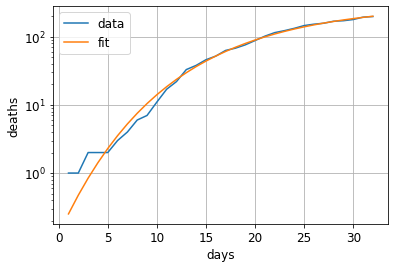

In [8]:
plt.ylabel("deaths")
plt.xlabel("days")
plt.yscale("log")
plt.grid()
plt.plot(x, y, label="data")
plt.plot(x, np.exp(lm - np.exp(A @ par)), label="fit")
p=plt.legend()

### <div align="justify"> 2. spočtěte korelační koeficient mezi parametry $p_i$ a určete hodnotu $l_0$ (včetně nejistoty)</div>
<div align="justify"> Korelační koeficient mezi parametry určím z korelační matice, kterou získám z inverzní Hessovy matice (kovarianční matice) a nejistot příslušných koeficientů.</div>

In [9]:
cov = np.linalg.inv(hess)
err = np.sqrt(cov.diagonal())
cor = cov / err[:,np.newaxis] / err[np.newaxis,:]
cor

array([[ 1.        , -0.91282746],
       [-0.91282746,  1.        ]])

Korelační koeficient mezi parametry $p_0$ a $p_1$ je $\,$-91.3%, tyto parametry jsou tedy v silné antikorelaci.

<div style="text-align: justify"> 
Hodnotu koeficientu $l_0$ určím jako zpětnou transformaci pro parametr $p_0$: $\,l_0 = \exp(p_0)$ a nejistoty určím pomocí nejistot parametru $p_0$:
</div>

$$\,\sigma_{l_0} = \sigma_{p_0} \, \left( \frac{\partial l_0}{\partial p_0} \right) = \sigma_{p_0} \exp(p_0).$$

Případně mohu nejistotu vyjadřit přímým dosazením, címž získám asymetrickou odchylku:

$$\sigma_{l_0} = \pm \exp(p_0 \pm \sigma_{p_0}) \mp \exp(p_0).$$

In [10]:
p0_e = err[0]
l0 = np.exp(p0)
l0_e = l0 * p0_e
l1 = -p1
l0_min, l0_max = np.exp(p0-p0_e), np.exp(p0+p0_e)
print("Asymetric: l_0 = {0:.3f} + {1:.3f} - {2:.3f}\nSymetric: l_0 = {0:.3f} +/- {3:.3f}"\
      .format(l0, l0_max-l0, l0-l0_min, l0_e))

Asymetric: l_0 = 7.760 + 0.365 - 0.348
Symetric: l_0 = 7.760 +/- 0.357


### <div align="justify">3. předpovězte hodnotu modelu v bodě $t=50$ a $t=70$ dní od počátku statistické řady</div>

Nejistoty pro extrapolované hodnoty určím podle vaší nápovědy v [diskuzi k zápočtové úloze](https://is.muni.cz/auth/discussion/zapforum/upresneni/?lang=cs): vytvořím matici 3x3, která bude odpovídat korelační matici rozšířené o parametr $l_m$, kdy korelaci mezi parametry $l_m$ a $p_0$ a $p_1$ položím rovnu nule. Výsledný rozptyl extrapolované hodnoty se spočte ze vzorce:

$$ D(y_e) = D^T V D,$$
kde
$$D_i = \frac{\partial y}{\partial p_i}.$$

In [11]:
cor2 = np.eye(3)
cor2[1,2]=cor[0,1]
cor2[2,1]=cor[0,1]
cor2

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -0.91282746],
       [ 0.        , -0.91282746,  1.        ]])

In [12]:
err2 = np.concatenate(([lm_e], err))
cov2 = cor2 * err2[np.newaxis,:] * err2[:,np.newaxis]
cov2

array([[ 5.76000000e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.11108611e-03, -1.10515738e-04],
       [ 0.00000000e+00, -1.10515738e-04,  6.94328377e-06]])

In [13]:
model = lambda x,p0,p1: np.exp(lm-np.exp(p0+p1*x))

def extrapolate(T):
    D_lm = model(T,p0,p1)
    D_p0 = model(T,p0,p1) * (-np.exp(p0+p1*T))
    D_p1 = model(T,p0,p1) * np.exp(p0+p1*T) * (-T)
    D = np.array([D_lm, D_p0, D_p1])
    sig_y = np.sqrt(D @ cov2 @ D)
    return model(T,p0,p1), sig_y

In [14]:
print("Počet obětí za 50 dní: {0:.1f} +/- {1:.1f}\nPočet obětí za 70 dní: {2:.1f} +/- {3:.1f}"\
      .format(*extrapolate(50), *extrapolate(70)))

Počet obětí za 50 dní: 274.1 +/- 6.8
Počet obětí za 70 dní: 291.2 +/- 7.0


## <div align="justify">B) Určete, zda lze zamítnout určený model na zvolené hladině významnosti (např. 95%) na základě dalšího vývoje - spočtěte chi kvadrát veličinu pro celou zadanou časovou řadu a porovnejte s příslušným kvantilem $\chi^2$ rozdělení</div>

In [15]:
x2, y2 = days, deaths
N2 = len(days)
z2 = np.log(lm - np.log(y2))
z2_e_lm = lm_e / (lm - np.log(y2))
z2_e_y = 1 / (np.sqrt(y2) * (lm - np.log(y2)))
z2_e = np.sqrt(z2_e_lm**2 + z2_e_y**2)
A2 = np.array([np.ones_like(x2), x2]).T

In [16]:
# z2 = log(lm - log(y2))
w2_z = np.eye(N2)
i2 = np.r_[:N2]
w2_z[i2,i2] = 1 / z2_e**2

resid2_z = z2 - A2 @ par
chi2 = resid2_z @ w2_z @ resid2_z
chi2

11.359833290265227

In [17]:
for q in [0.9999999, 0.999999, 0.99999, 0.9999, 0.999, 0.05]:
    print("{0:.3g}%: {1:.4g}".format((1-q)*100,stat.chi2(N2-2).isf(q)))

1e-05%: 11.52
0.0001%: 13.23
0.001%: 15.3
0.01%: 17.89
0.1%: 21.25
95%: 61.66


<div align="justify">Pro celou časovou řadu jsem získal $\chi^2$ = 11.36. Pro 45 stupňů volnosti a hladinu významnosti 0.00001% tedy lze tento model zamítnout.</div>

$\chi^2$ v proměnné $t = \log(y)$ spočtený pro 32 dnů:

In [18]:
t = np.log(y)
w_t = np.eye(N)
w_t[i,i] = y

resid_t = t - (lm - np.exp(A @ par))
chi2_t = resid_t @ w_t @ resid_t
chi2_t

8.987055469694889

## <div align="justify">C) Zafixováním parametru $p_1=-l_1$ můžete funkci (1) brát jako lineární v $l_m$ a $l_0$ - zkuste nyní spočíst nově tyto 2 parametry včetně nejistot. Jak se změní $\chi^2$ (vážená suma čtverců reziduí) oproti hodnotě získaném v předchozím bodě?</div>

Tentokrát provedu transformaci $t = log(y)$, nejistotu $\sigma_t$ získám opět ze zákona šíření chyb za předpokladu Poissonovského rozdělení měřené veličiny $D(y) = y$

$$ \sigma_t = \sigma_y \, \frac{\partial t}{\partial y} = \sqrt{y} \, \frac{1}{y} = \frac{1}{\sqrt{y}}.$$

Zásadní změnou od předchozího případu bude fakt, že na druhém místě matice ***A*** bude místo $x$ výraz $\exp(-l_1 x)$, jinak je postup víceméně totožný.

In [19]:
A3 = np.array([np.ones_like(x), -np.exp(-l1*x)]).T
hess3 = A3.T @ w_t @ A3
cov3 = np.linalg.inv(hess3)
par3 = cov3 @ A3.T @ w_t @ t
err3 = np.sqrt(cov3.diagonal())
print("lm = {0:.3f} +/- {1:.3f}\nl0 = {2:.2f} +/- {3:.2f}".format(par3[0], err3[0], par3[1], err3[1]))

lm = 5.682 +/- 0.035
l0 = 7.71 +/- 0.25


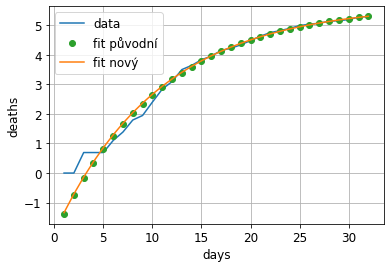

In [20]:
plt.xlabel("days")
plt.ylabel("deaths")
plt.plot(x,t,label="data")
plt.grid()
plt.plot(x, np.log(model(x,p0,p1)), "o", label="fit původní", c="C2")
plt.plot(x, A3 @ par3, label="fit nový", c="C1")
p=plt.legend()

$\chi^2$ v proměnné $t = \log(y)$ spočtený pro 32 dnů:

In [21]:
resid_t = t - A3 @ par3
chi2_4 = resid_t @ w_t @ resid_t
chi2_4

8.916319853069458

Nyní bude $\chi^2$ nabývat hodnoty 8.916, zatímco v předchozím případě to bylo 8.987. Při zafixování parametru $l_1$ a minimalizaci parametrů $l_m$ a $l_0$ jsme tedy fit nepatrně "vylepšili".